============================================================================
HAND SIGN RECOGNITION - CUSTOM CNN FROM SCRATCH
Jupyter Notebook - Complete Training Pipeline
============================================================================
 
Requirements:
 - Custom CNN architecture (NO transfer learning)
 - Training/Validation loss & accuracy curves
 - Testing results with confusion matrix
 - Complete evaluation metrics

============================================================================

In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.metrics import (confusion_matrix, classification_report, 
                            accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Choose your framework: 'pytorch' or 'keras'
FRAMEWORK = 'pytorch'  # Change to 'keras' if you prefer

if FRAMEWORK == 'pytorch':
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torchvision.transforms as transforms
    print(f"✅ Using PyTorch {torch.__version__}")
    print(f"✅ CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    print(f"✅ Using TensorFlow {tf.__version__}")
    print(f"✅ GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("="*80)
print("🚀 HAND SIGN RECOGNITION - CUSTOM CNN TRAINING")
print("="*80)


✅ Using PyTorch 2.7.1+cu118
✅ CUDA Available: True
✅ GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
🚀 HAND SIGN RECOGNITION - CUSTOM CNN TRAINING


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

class Config:
    # Paths - CHANGE THESE TO YOUR DATASET PATHS
    TRAIN_DIR = 'dataset_augmented/train'  # or 'dataset_cleaned/train'
    VALID_DIR = 'dataset_augmented/valid'  # or 'dataset_cleaned/valid'
    TEST_DIR = 'dataset_augmented/test'    # or 'dataset_cleaned/test'
    
    # Model parameters
    IMG_SIZE = 224  # Image size (224x224)
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 0.001
    
    # Number of classes -
    NUM_CLASSES = 28  
    
    # Training settings
    EARLY_STOPPING_PATIENCE = 10
    REDUCE_LR_PATIENCE = 5
    
    # Device
    DEVICE = 'cuda' if FRAMEWORK == 'pytorch' and torch.cuda.is_available() else 'cpu'
    
    # Random seed for reproducibility
    SEED = 42

config = Config()

print(f"\n📁 Dataset Paths:")
print(f"   Train: {config.TRAIN_DIR}")
print(f"   Valid: {config.VALID_DIR}")
print(f"   Test:  {config.TEST_DIR}")
print(f"\n⚙️  Configuration:")
print(f"   Image Size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Learning Rate: {config.LEARNING_RATE}")
print(f"   Device: {config.DEVICE}")
print(f"   Number of Classes: {config.NUM_CLASSES}")

# Set seeds
np.random.seed(config.SEED)
if FRAMEWORK == 'pytorch':
    torch.manual_seed(config.SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config.SEED)
else:
    tf.random.set_seed(config.SEED)


📁 Dataset Paths:
   Train: dataset_augmented/train
   Valid: dataset_augmented/valid
   Test:  dataset_augmented/test

⚙️  Configuration:
   Image Size: 224x224
   Batch Size: 32
   Epochs: 50
   Learning Rate: 0.001
   Device: cuda
   Number of Classes: 28


In [3]:
# ============================================================================
# SECTION 3: DATA LOADING - PYTORCH
# ============================================================================

if FRAMEWORK == 'pytorch':
    
    class HandSignDataset(Dataset):
        """Custom Dataset for Hand Sign Recognition - Optimized with caching"""
        
        def __init__(self, data_dir, transform=None, cache_images=True):
            self.data_dir = data_dir
            self.transform = transform
            self.cache_images = cache_images
            self.images = []
            self.labels = []
            self.image_cache = {}  # Cache for loaded images
            
            print(f"   Loading dataset from {data_dir}...")
            
            # Load images and labels from YOLO format
            images_dir = os.path.join(data_dir, 'images')
            labels_dir = os.path.join(data_dir, 'labels')
            
            if not os.path.exists(images_dir):
                raise ValueError(f"Images directory not found: {images_dir}")
            
            # Get all image files
            image_files = [f for f in os.listdir(images_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            
            print(f"   Found {len(image_files)} images, processing...")
            
            for idx, img_file in enumerate(image_files):
                img_path = os.path.join(images_dir, img_file)
                
                # Get corresponding label file
                label_file = os.path.splitext(img_file)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_file)
                
                if os.path.exists(label_path):
                    # Read the first line (assuming one object per image)
                    with open(label_path, 'r') as f:
                        line = f.readline().strip()
                        if line:
                            class_id = int(line.split()[0])
                            self.images.append(img_path)
                            self.labels.append(class_id)
                
                # Progress indicator
                if (idx + 1) % 1000 == 0:
                    print(f"   Processed {idx + 1}/{len(image_files)} images...")
            
            print(f"   ✅ Loaded {len(self.images)} valid images")
            
            # Pre-load all images into memory if cache_images=True
            if cache_images and len(self.images) < 5000:  # Only cache if dataset is small enough
                print(f"   📦 Caching images in memory...")
                for idx, img_path in enumerate(self.images):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        self.image_cache[idx] = img
                        
                        if (idx + 1) % 1000 == 0:
                            print(f"   Cached {idx + 1}/{len(self.images)} images...")
                    except Exception as e:
                        print(f"   ⚠️ Error caching {img_path}: {e}")
                
                print(f"   ✅ All images cached in memory!")
        
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            label = self.labels[idx]
            
            # Load from cache or disk
            if idx in self.image_cache:
                image = self.image_cache[idx].copy()
            else:
                img_path = self.images[idx]
                image = Image.open(img_path).convert('RGB')
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            return image, label
    
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    print("\n📦 Loading Datasets...")
    train_dataset = HandSignDataset(config.TRAIN_DIR, transform=train_transform, cache_images=False)
    valid_dataset = HandSignDataset(config.VALID_DIR, transform=test_transform, cache_images=True)
    test_dataset = HandSignDataset(config.TEST_DIR, transform=test_transform, cache_images=True)
    
    print(f"\n   ✅ Train: {len(train_dataset)} images (not cached - too large)")
    print(f"   ✅ Valid: {len(valid_dataset)} images (cached in memory)")
    print(f"   ✅ Test:  {len(test_dataset)} images (cached in memory)")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, 
                             shuffle=True, num_workers=0, pin_memory=True,
                             persistent_workers=False, prefetch_factor=None)
    valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, 
                             shuffle=False, num_workers=0, pin_memory=True,
                             persistent_workers=False, prefetch_factor=None)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, 
                            shuffle=False, num_workers=0, pin_memory=True,
                            persistent_workers=False, prefetch_factor=None)

# ============================================================================
# SECTION 4: DATA LOADING - KERAS
# ============================================================================

else:  # FRAMEWORK == 'keras'
    
    def create_dataframe(data_dir):
        """Create a dataframe for ImageDataGenerator"""
        images_dir = os.path.join(data_dir, 'images')
        labels_dir = os.path.join(data_dir, 'labels')
        
        data = []
        for img_file in os.listdir(images_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                img_path = os.path.join(images_dir, img_file)
                
                # Get corresponding label
                label_file = os.path.splitext(img_file)[0] + '.txt'
                label_path = os.path.join(labels_dir, label_file)
                
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        line = f.readline().strip()
                        if line:
                            class_id = int(line.split()[0])
                            data.append({
                                'filename': img_path,
                                'class': str(class_id)
                            })
        
        return pd.DataFrame(data)
    
    print("\n📦 Loading Datasets...")
    train_df = create_dataframe(config.TRAIN_DIR)
    valid_df = create_dataframe(config.VALID_DIR)
    test_df = create_dataframe(config.TEST_DIR)
    
    print(f"   ✅ Train: {len(train_df)} images")
    print(f"   ✅ Valid: {len(valid_df)} images")
    print(f"   ✅ Test:  {len(test_df)} images")
    
    # Create data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(config.IMG_SIZE, config.IMG_SIZE),
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    valid_generator = test_datagen.flow_from_dataframe(
        valid_df,
        x_col='filename',
        y_col='class',
        target_size=(config.IMG_SIZE, config.IMG_SIZE),
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=(config.IMG_SIZE, config.IMG_SIZE),
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )



📦 Loading Datasets...
   Loading dataset from dataset_augmented/train...
   Found 16852 images, processing...
   Processed 1000/16852 images...
   Processed 2000/16852 images...
   Processed 3000/16852 images...
   Processed 4000/16852 images...
   Processed 5000/16852 images...
   Processed 6000/16852 images...
   Processed 7000/16852 images...
   Processed 8000/16852 images...
   Processed 9000/16852 images...
   Processed 10000/16852 images...
   Processed 11000/16852 images...
   Processed 12000/16852 images...
   Processed 13000/16852 images...
   Processed 14000/16852 images...
   Processed 15000/16852 images...
   Processed 16000/16852 images...
   ✅ Loaded 16852 valid images
   Loading dataset from dataset_augmented/valid...
   Found 801 images, processing...
   ✅ Loaded 780 valid images
   📦 Caching images in memory...
   ✅ All images cached in memory!
   Loading dataset from dataset_augmented/test...
   Found 270 images, processing...
   ✅ Loaded 270 valid images
   📦 Cachin

In [4]:
# ============================================================================
# SECTION 5: CUSTOM CNN ARCHITECTURE - PYTORCH
# ============================================================================

if FRAMEWORK == 'pytorch':
    
    class HandSignCNN(nn.Module):
        """
        Custom CNN Architecture for Hand Sign Recognition
        
        Architecture:
        - 4 Convolutional Blocks (Conv -> BN -> ReLU -> MaxPool)
        - Increasing filters: 32 -> 64 -> 128 -> 256
        - Global Average Pooling
        - 2 Fully Connected Layers with Dropout
        - Output layer with Softmax
        """
        
        def __init__(self, num_classes=10):
            super(HandSignCNN, self).__init__()
            
            # Convolutional Block 1
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25)
            )
            
            # Convolutional Block 2
            self.conv2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25)
            )
            
            # Convolutional Block 3
            self.conv3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25)
            )
            
            # Convolutional Block 4
            self.conv4 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25)
            )
            
            # Global Average Pooling
            self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
            
            # Fully Connected Layers
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(256, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes)
            )
        
        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            x = self.global_avg_pool(x)
            x = self.fc(x)
            return x
    
    # Create model
    print("\n🏗️  Building Custom CNN Architecture...")
    model = HandSignCNN(num_classes=config.NUM_CLASSES).to(config.DEVICE)
    
    # Print model summary
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"   ✅ Model created successfully!")
    print(f"   📊 Total trainable parameters: {count_parameters(model):,}")
    print(f"\n   Model Architecture:")
    print(model)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=config.REDUCE_LR_PATIENCE)

# ============================================================================
# SECTION 6: CUSTOM CNN ARCHITECTURE - KERAS
# ============================================================================

else:  # FRAMEWORK == 'keras'
    
    def create_hand_sign_cnn(num_classes=10, input_shape=(224, 224, 3)):
        """
        Custom CNN Architecture for Hand Sign Recognition
        
        Architecture:
        - 4 Convolutional Blocks (Conv -> BN -> ReLU -> MaxPool)
        - Increasing filters: 32 -> 64 -> 128 -> 256
        - Global Average Pooling
        - 2 Fully Connected Layers with Dropout
        - Output layer with Softmax
        """
        
        model = models.Sequential([
            # Convolutional Block 1
            layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(32, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.25),
            
            # Convolutional Block 2
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.25),
            
            # Convolutional Block 3
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.25),
            
            # Convolutional Block 4
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(256, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.25),
            
            # Global Average Pooling
            layers.GlobalAveragePooling2D(),
            
            # Fully Connected Layers
            layers.Dense(512),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.5),
            layers.Dense(256),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        return model
    
    # Create model
    print("\n🏗️  Building Custom CNN Architecture...")
    model = create_hand_sign_cnn(num_classes=config.NUM_CLASSES, 
                                 input_shape=(config.IMG_SIZE, config.IMG_SIZE, 3))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Print model summary
    print(f"   ✅ Model created successfully!")
    model.summary()
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=config.EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=config.REDUCE_LR_PATIENCE,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]


🏗️  Building Custom CNN Architecture...
   ✅ Model created successfully!
   📊 Total trainable parameters: 1,445,820

   Model Architecture:
HandSignCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d

In [5]:
# ============================================================================
# SECTION 7: TRAINING LOOP - PYTORCH
# ============================================================================

if FRAMEWORK == 'pytorch':
    
    from tqdm import tqdm
    
    def train_epoch(model, loader, criterion, optimizer, device, epoch, total_epochs):
        """Train for one epoch with progress bar"""
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar
        pbar = tqdm(loader, desc=f'Epoch {epoch}/{total_epochs} [TRAIN]', 
                   leave=True, ncols=100)
        
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_loss = running_loss / total
            current_acc = correct / total
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.4f}'
            })
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def validate(model, loader, criterion, device, epoch, total_epochs):
        """Validate the model with progress bar"""
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Progress bar
        pbar = tqdm(loader, desc=f'Epoch {epoch}/{total_epochs} [VALID]', 
                   leave=True, ncols=100)
        
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar
                current_loss = running_loss / total
                current_acc = correct / total
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'acc': f'{current_acc:.4f}'
                })
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    # Training
    print("\n🎯 Starting Training...")
    print("="*80)
    print(f"Total Epochs: {config.EPOCHS}")
    print(f"Batch Size: {config.BATCH_SIZE}")
    print(f"Learning Rate: {config.LEARNING_RATE}")
    print(f"Device: {config.DEVICE}")
    print("="*80)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    
    import time
    start_time = time.time()
    
    for epoch in range(config.EPOCHS):
        epoch_start = time.time()
        
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{config.EPOCHS}")
        print(f"{'='*80}")
        
        # Train - with real-time progress bar
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, 
                                           config.DEVICE, epoch+1, config.EPOCHS)
        
        # Validate - with real-time progress bar
        val_loss, val_acc = validate(model, valid_loader, criterion, 
                                    config.DEVICE, epoch+1, config.EPOCHS)
        
        # Update learning rate
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start
        
        # Print results immediately after epoch
        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"  Train → Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
        print(f"  Valid → Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
        print(f"  Time: {epoch_time:.2f}s")
        
        if new_lr != old_lr:
            print(f"  📉 LR Changed: {old_lr:.6f} → {new_lr:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  ✅ BEST MODEL SAVED! (Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%)")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement - Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")
            
            if patience_counter >= config.EARLY_STOPPING_PATIENCE:
                print(f"\n⚠️  Early stopping triggered!")
                break
        
        # Flush output to ensure immediate printing
        import sys
        sys.stdout.flush()
    
    # Training summary
    total_time = time.time() - start_time
    print(f"\n{'='*80}")
    print("✅ TRAINING COMPLETE!")
    print(f"{'='*80}")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Best Val Loss: {best_val_loss:.4f}")
    print(f"Best Val Acc: {best_val_acc*100:.2f}%")
    print(f"{'='*80}")
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    print("✅ Best model loaded!")

# ============================================================================
# SECTION 8: TRAINING - KERAS
# ============================================================================

else:  # FRAMEWORK == 'keras'
    
    print("\n🎯 Starting Training...")
    print("="*80)
    
    history = model.fit(
        train_generator,
        epochs=config.EPOCHS,
        validation_data=valid_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\n✅ Training Complete!")


🎯 Starting Training...
Total Epochs: 50
Batch Size: 32
Learning Rate: 0.001
Device: cuda

Epoch 1/50


Epoch 1/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.52it/s, loss=3.2626, acc=0.0513]



📊 Epoch 1 Results:
  Train → Loss: 3.3660 | Acc: 4.91%
  Valid → Loss: 3.2626 | Acc: 5.13%
  Time: 206.78s
  ✅ BEST MODEL SAVED! (Val Loss: 3.2626, Val Acc: 5.13%)

Epoch 2/50


Epoch 2/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.56it/s, loss=3.2090, acc=0.0872]


📊 Epoch 2 Results:
  Train → Loss: 3.2815 | Acc: 6.03%
  Valid → Loss: 3.2090 | Acc: 8.72%
  Time: 196.63s
  ✅ BEST MODEL SAVED! (Val Loss: 3.2090, Val Acc: 8.72%)



Epoch 3/50


Epoch 3/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.56it/s, loss=3.1606, acc=0.0897]


📊 Epoch 3 Results:
  Train → Loss: 3.2454 | Acc: 6.60%
  Valid → Loss: 3.1606 | Acc: 8.97%
  Time: 199.62s
  ✅ BEST MODEL SAVED! (Val Loss: 3.1606, Val Acc: 8.97%)



Epoch 4/50


Epoch 4/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.57it/s, loss=3.1783, acc=0.0846]


📊 Epoch 4 Results:
  Train → Loss: 3.2175 | Acc: 6.89%
  Valid → Loss: 3.1783 | Acc: 8.46%
  Time: 196.12s
  ⏳ No improvement - Patience: 1/10



Epoch 5/50


Epoch 5/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.43it/s, loss=3.1301, acc=0.0987]


📊 Epoch 5 Results:
  Train → Loss: 3.1890 | Acc: 7.79%
  Valid → Loss: 3.1301 | Acc: 9.87%
  Time: 190.75s
  ✅ BEST MODEL SAVED! (Val Loss: 3.1301, Val Acc: 9.87%)



Epoch 6/50


Epoch 6/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.47it/s, loss=3.1278, acc=0.1026]


📊 Epoch 6 Results:
  Train → Loss: 3.1665 | Acc: 7.98%
  Valid → Loss: 3.1278 | Acc: 10.26%
  Time: 200.16s
  ✅ BEST MODEL SAVED! (Val Loss: 3.1278, Val Acc: 10.26%)



Epoch 7/50


Epoch 7/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  8.01it/s, loss=3.0932, acc=0.1038]


📊 Epoch 7 Results:
  Train → Loss: 3.1507 | Acc: 8.57%
  Valid → Loss: 3.0932 | Acc: 10.38%
  Time: 197.84s
  ✅ BEST MODEL SAVED! (Val Loss: 3.0932, Val Acc: 10.38%)



Epoch 8/50


Epoch 8/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.50it/s, loss=3.0778, acc=0.1013]


📊 Epoch 8 Results:
  Train → Loss: 3.1216 | Acc: 9.10%
  Valid → Loss: 3.0778 | Acc: 10.13%
  Time: 194.23s
  ✅ BEST MODEL SAVED! (Val Loss: 3.0778, Val Acc: 10.13%)



Epoch 9/50


Epoch 9/50 [VALID]: 100%|██████████████████| 25/25 [00:03<00:00,  7.71it/s, loss=3.0188, acc=0.1115]


📊 Epoch 9 Results:
  Train → Loss: 3.1061 | Acc: 9.79%
  Valid → Loss: 3.0188 | Acc: 11.15%
  Time: 196.45s
  ✅ BEST MODEL SAVED! (Val Loss: 3.0188, Val Acc: 11.15%)



Epoch 10/50


Epoch 10/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.53it/s, loss=3.0197, acc=0.1256]


📊 Epoch 10 Results:
  Train → Loss: 3.0757 | Acc: 10.18%
  Valid → Loss: 3.0197 | Acc: 12.56%
  Time: 196.06s
  ⏳ No improvement - Patience: 1/10



Epoch 11/50


Epoch 11/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.78it/s, loss=2.9174, acc=0.1321]


📊 Epoch 11 Results:
  Train → Loss: 3.0474 | Acc: 11.08%
  Valid → Loss: 2.9174 | Acc: 13.21%
  Time: 187.78s
  ✅ BEST MODEL SAVED! (Val Loss: 2.9174, Val Acc: 13.21%)



Epoch 12/50


Epoch 12/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.50it/s, loss=2.8429, acc=0.1654]


📊 Epoch 12 Results:
  Train → Loss: 2.9862 | Acc: 12.16%
  Valid → Loss: 2.8429 | Acc: 16.54%
  Time: 194.12s
  ✅ BEST MODEL SAVED! (Val Loss: 2.8429, Val Acc: 16.54%)



Epoch 13/50


Epoch 13/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.63it/s, loss=2.7219, acc=0.2000]


📊 Epoch 13 Results:
  Train → Loss: 2.9342 | Acc: 13.80%
  Valid → Loss: 2.7219 | Acc: 20.00%
  Time: 195.19s
  ✅ BEST MODEL SAVED! (Val Loss: 2.7219, Val Acc: 20.00%)



Epoch 14/50


Epoch 14/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.68it/s, loss=2.5825, acc=0.1962]


📊 Epoch 14 Results:
  Train → Loss: 2.8400 | Acc: 15.91%
  Valid → Loss: 2.5825 | Acc: 19.62%
  Time: 186.95s
  ✅ BEST MODEL SAVED! (Val Loss: 2.5825, Val Acc: 19.62%)



Epoch 15/50


Epoch 15/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.57it/s, loss=2.2971, acc=0.2987]



📊 Epoch 15 Results:
  Train → Loss: 2.7134 | Acc: 19.29%
  Valid → Loss: 2.2971 | Acc: 29.87%
  Time: 192.52s
  ✅ BEST MODEL SAVED! (Val Loss: 2.2971, Val Acc: 29.87%)

Epoch 16/50


Epoch 16/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  8.18it/s, loss=2.0542, acc=0.3474]


📊 Epoch 16 Results:
  Train → Loss: 2.5219 | Acc: 24.22%
  Valid → Loss: 2.0542 | Acc: 34.74%
  Time: 192.60s
  ✅ BEST MODEL SAVED! (Val Loss: 2.0542, Val Acc: 34.74%)



Epoch 17/50


Epoch 17/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.72it/s, loss=1.6857, acc=0.4705]


📊 Epoch 17 Results:
  Train → Loss: 2.3044 | Acc: 29.47%
  Valid → Loss: 1.6857 | Acc: 47.05%
  Time: 187.63s
  ✅ BEST MODEL SAVED! (Val Loss: 1.6857, Val Acc: 47.05%)



Epoch 18/50


Epoch 18/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.76it/s, loss=1.4493, acc=0.5667]


📊 Epoch 18 Results:
  Train → Loss: 2.0907 | Acc: 35.12%
  Valid → Loss: 1.4493 | Acc: 56.67%
  Time: 189.56s
  ✅ BEST MODEL SAVED! (Val Loss: 1.4493, Val Acc: 56.67%)



Epoch 19/50


Epoch 19/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.81it/s, loss=1.1454, acc=0.6551]


📊 Epoch 19 Results:
  Train → Loss: 1.8816 | Acc: 41.63%
  Valid → Loss: 1.1454 | Acc: 65.51%
  Time: 194.81s
  ✅ BEST MODEL SAVED! (Val Loss: 1.1454, Val Acc: 65.51%)



Epoch 20/50


Epoch 20/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.02it/s, loss=0.9953, acc=0.7064]


📊 Epoch 20 Results:
  Train → Loss: 1.6515 | Acc: 48.56%
  Valid → Loss: 0.9953 | Acc: 70.64%
  Time: 192.66s
  ✅ BEST MODEL SAVED! (Val Loss: 0.9953, Val Acc: 70.64%)



Epoch 21/50


Epoch 21/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.14it/s, loss=0.8448, acc=0.7359]


📊 Epoch 21 Results:
  Train → Loss: 1.4592 | Acc: 55.08%
  Valid → Loss: 0.8448 | Acc: 73.59%
  Time: 198.45s
  ✅ BEST MODEL SAVED! (Val Loss: 0.8448, Val Acc: 73.59%)



Epoch 22/50


Epoch 22/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.58it/s, loss=0.6913, acc=0.7949]


📊 Epoch 22 Results:
  Train → Loss: 1.2870 | Acc: 60.45%
  Valid → Loss: 0.6913 | Acc: 79.49%
  Time: 194.05s
  ✅ BEST MODEL SAVED! (Val Loss: 0.6913, Val Acc: 79.49%)



Epoch 23/50


Epoch 23/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.90it/s, loss=0.5573, acc=0.8359]


📊 Epoch 23 Results:
  Train → Loss: 1.1524 | Acc: 64.20%
  Valid → Loss: 0.5573 | Acc: 83.59%
  Time: 185.92s
  ✅ BEST MODEL SAVED! (Val Loss: 0.5573, Val Acc: 83.59%)



Epoch 24/50


Epoch 24/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.90it/s, loss=0.4442, acc=0.8731]


📊 Epoch 24 Results:
  Train → Loss: 1.0223 | Acc: 68.63%
  Valid → Loss: 0.4442 | Acc: 87.31%
  Time: 188.71s
  ✅ BEST MODEL SAVED! (Val Loss: 0.4442, Val Acc: 87.31%)



Epoch 25/50


Epoch 25/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.63it/s, loss=0.4000, acc=0.8667]


📊 Epoch 25 Results:
  Train → Loss: 0.9299 | Acc: 71.53%
  Valid → Loss: 0.4000 | Acc: 86.67%
  Time: 195.65s
  ✅ BEST MODEL SAVED! (Val Loss: 0.4000, Val Acc: 86.67%)



Epoch 26/50


Epoch 26/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.55it/s, loss=0.3420, acc=0.8987]


📊 Epoch 26 Results:
  Train → Loss: 0.8344 | Acc: 73.90%
  Valid → Loss: 0.3420 | Acc: 89.87%
  Time: 187.65s
  ✅ BEST MODEL SAVED! (Val Loss: 0.3420, Val Acc: 89.87%)



Epoch 27/50


Epoch 27/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.49it/s, loss=0.3162, acc=0.9077]


📊 Epoch 27 Results:
  Train → Loss: 0.7444 | Acc: 77.08%
  Valid → Loss: 0.3162 | Acc: 90.77%
  Time: 205.23s
  ✅ BEST MODEL SAVED! (Val Loss: 0.3162, Val Acc: 90.77%)



Epoch 28/50


Epoch 28/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  8.03it/s, loss=0.2774, acc=0.9205]


📊 Epoch 28 Results:
  Train → Loss: 0.6998 | Acc: 78.33%
  Valid → Loss: 0.2774 | Acc: 92.05%
  Time: 195.64s
  ✅ BEST MODEL SAVED! (Val Loss: 0.2774, Val Acc: 92.05%)



Epoch 29/50


Epoch 29/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.05it/s, loss=0.2510, acc=0.9192]


📊 Epoch 29 Results:
  Train → Loss: 0.6346 | Acc: 80.70%
  Valid → Loss: 0.2510 | Acc: 91.92%
  Time: 195.77s
  ✅ BEST MODEL SAVED! (Val Loss: 0.2510, Val Acc: 91.92%)



Epoch 30/50


Epoch 30/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.75it/s, loss=0.2091, acc=0.9295]


📊 Epoch 30 Results:
  Train → Loss: 0.5813 | Acc: 81.90%
  Valid → Loss: 0.2091 | Acc: 92.95%
  Time: 190.98s
  ✅ BEST MODEL SAVED! (Val Loss: 0.2091, Val Acc: 92.95%)



Epoch 31/50


Epoch 31/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.66it/s, loss=0.2063, acc=0.9385]


📊 Epoch 31 Results:
  Train → Loss: 0.5271 | Acc: 83.62%
  Valid → Loss: 0.2063 | Acc: 93.85%
  Time: 195.50s
  ✅ BEST MODEL SAVED! (Val Loss: 0.2063, Val Acc: 93.85%)



Epoch 32/50


Epoch 32/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.98it/s, loss=0.1676, acc=0.9474]



📊 Epoch 32 Results:
  Train → Loss: 0.5192 | Acc: 84.24%
  Valid → Loss: 0.1676 | Acc: 94.74%
  Time: 192.58s
  ✅ BEST MODEL SAVED! (Val Loss: 0.1676, Val Acc: 94.74%)

Epoch 33/50


Epoch 33/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.47it/s, loss=0.1771, acc=0.9462]


📊 Epoch 33 Results:
  Train → Loss: 0.4779 | Acc: 85.22%
  Valid → Loss: 0.1771 | Acc: 94.62%
  Time: 186.36s
  ⏳ No improvement - Patience: 1/10



Epoch 34/50


Epoch 34/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.73it/s, loss=0.1698, acc=0.9449]


📊 Epoch 34 Results:
  Train → Loss: 0.4539 | Acc: 86.06%
  Valid → Loss: 0.1698 | Acc: 94.49%
  Time: 193.44s
  ⏳ No improvement - Patience: 2/10



Epoch 35/50


Epoch 35/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  8.17it/s, loss=0.1412, acc=0.9628]


📊 Epoch 35 Results:
  Train → Loss: 0.4130 | Acc: 87.72%
  Valid → Loss: 0.1412 | Acc: 96.28%
  Time: 186.21s
  ✅ BEST MODEL SAVED! (Val Loss: 0.1412, Val Acc: 96.28%)



Epoch 36/50


Epoch 36/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.59it/s, loss=0.1393, acc=0.9590]


📊 Epoch 36 Results:
  Train → Loss: 0.3922 | Acc: 88.00%
  Valid → Loss: 0.1393 | Acc: 95.90%
  Time: 186.24s
  ✅ BEST MODEL SAVED! (Val Loss: 0.1393, Val Acc: 95.90%)



Epoch 37/50


Epoch 37/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.64it/s, loss=0.1365, acc=0.9577]


📊 Epoch 37 Results:
  Train → Loss: 0.3721 | Acc: 88.61%
  Valid → Loss: 0.1365 | Acc: 95.77%
  Time: 191.52s
  ✅ BEST MODEL SAVED! (Val Loss: 0.1365, Val Acc: 95.77%)



Epoch 38/50


Epoch 38/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  8.13it/s, loss=0.1207, acc=0.9654]


📊 Epoch 38 Results:
  Train → Loss: 0.3602 | Acc: 89.15%
  Valid → Loss: 0.1207 | Acc: 96.54%
  Time: 196.95s
  ✅ BEST MODEL SAVED! (Val Loss: 0.1207, Val Acc: 96.54%)



Epoch 39/50


Epoch 39/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.70it/s, loss=0.1239, acc=0.9526]


📊 Epoch 39 Results:
  Train → Loss: 0.3231 | Acc: 90.10%
  Valid → Loss: 0.1239 | Acc: 95.26%
  Time: 192.83s
  ⏳ No improvement - Patience: 1/10



Epoch 40/50


Epoch 40/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.68it/s, loss=0.1386, acc=0.9513]


📊 Epoch 40 Results:
  Train → Loss: 0.3107 | Acc: 90.66%
  Valid → Loss: 0.1386 | Acc: 95.13%
  Time: 198.37s
  ⏳ No improvement - Patience: 2/10



Epoch 41/50


Epoch 41/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.87it/s, loss=0.1020, acc=0.9679]



📊 Epoch 41 Results:
  Train → Loss: 0.2944 | Acc: 90.90%
  Valid → Loss: 0.1020 | Acc: 96.79%
  Time: 193.16s
  ✅ BEST MODEL SAVED! (Val Loss: 0.1020, Val Acc: 96.79%)

Epoch 42/50


Epoch 42/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  6.84it/s, loss=0.1108, acc=0.9654]


📊 Epoch 42 Results:
  Train → Loss: 0.2844 | Acc: 91.22%
  Valid → Loss: 0.1108 | Acc: 96.54%
  Time: 182.97s
  ⏳ No improvement - Patience: 1/10



Epoch 43/50


Epoch 43/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.53it/s, loss=0.0917, acc=0.9731]


📊 Epoch 43 Results:
  Train → Loss: 0.2832 | Acc: 91.28%
  Valid → Loss: 0.0917 | Acc: 97.31%
  Time: 194.11s
  ✅ BEST MODEL SAVED! (Val Loss: 0.0917, Val Acc: 97.31%)



Epoch 44/50


Epoch 44/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.45it/s, loss=0.1025, acc=0.9718]


📊 Epoch 44 Results:
  Train → Loss: 0.2599 | Acc: 91.82%
  Valid → Loss: 0.1025 | Acc: 97.18%
  Time: 198.96s
  ⏳ No improvement - Patience: 1/10



Epoch 45/50


Epoch 45/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.75it/s, loss=0.1049, acc=0.9679]


📊 Epoch 45 Results:
  Train → Loss: 0.2447 | Acc: 92.55%
  Valid → Loss: 0.1049 | Acc: 96.79%
  Time: 187.10s
  ⏳ No improvement - Patience: 2/10



Epoch 46/50


Epoch 46/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.45it/s, loss=0.1061, acc=0.9692]


📊 Epoch 46 Results:
  Train → Loss: 0.2386 | Acc: 92.70%
  Valid → Loss: 0.1061 | Acc: 96.92%
  Time: 189.15s
  ⏳ No improvement - Patience: 3/10



Epoch 47/50


Epoch 47/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.61it/s, loss=0.1147, acc=0.9641]


📊 Epoch 47 Results:
  Train → Loss: 0.2408 | Acc: 92.91%
  Valid → Loss: 0.1147 | Acc: 96.41%
  Time: 199.33s
  ⏳ No improvement - Patience: 4/10



Epoch 48/50


Epoch 48/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.74it/s, loss=0.0757, acc=0.9692]



📊 Epoch 48 Results:
  Train → Loss: 0.2086 | Acc: 93.69%
  Valid → Loss: 0.0757 | Acc: 96.92%
  Time: 187.36s
  ✅ BEST MODEL SAVED! (Val Loss: 0.0757, Val Acc: 96.92%)

Epoch 49/50


Epoch 49/50 [VALID]: 100%|█████████████████| 25/25 [00:03<00:00,  7.69it/s, loss=0.0704, acc=0.9821]


📊 Epoch 49 Results:
  Train → Loss: 0.2189 | Acc: 93.24%
  Valid → Loss: 0.0704 | Acc: 98.21%
  Time: 196.75s
  ✅ BEST MODEL SAVED! (Val Loss: 0.0704, Val Acc: 98.21%)



Epoch 50/50


Epoch 50/50 [VALID]: 100%|█████████████████| 25/25 [00:08<00:00,  2.94it/s, loss=0.0577, acc=0.9808]



📊 Epoch 50 Results:
  Train → Loss: 0.2061 | Acc: 93.79%
  Valid → Loss: 0.0577 | Acc: 98.08%
  Time: 214.60s
  ✅ BEST MODEL SAVED! (Val Loss: 0.0577, Val Acc: 98.08%)

✅ TRAINING COMPLETE!
Total Time: 161.52 minutes
Best Val Loss: 0.0577
Best Val Acc: 98.08%
✅ Best model loaded!



📊 Plotting Training Curves...


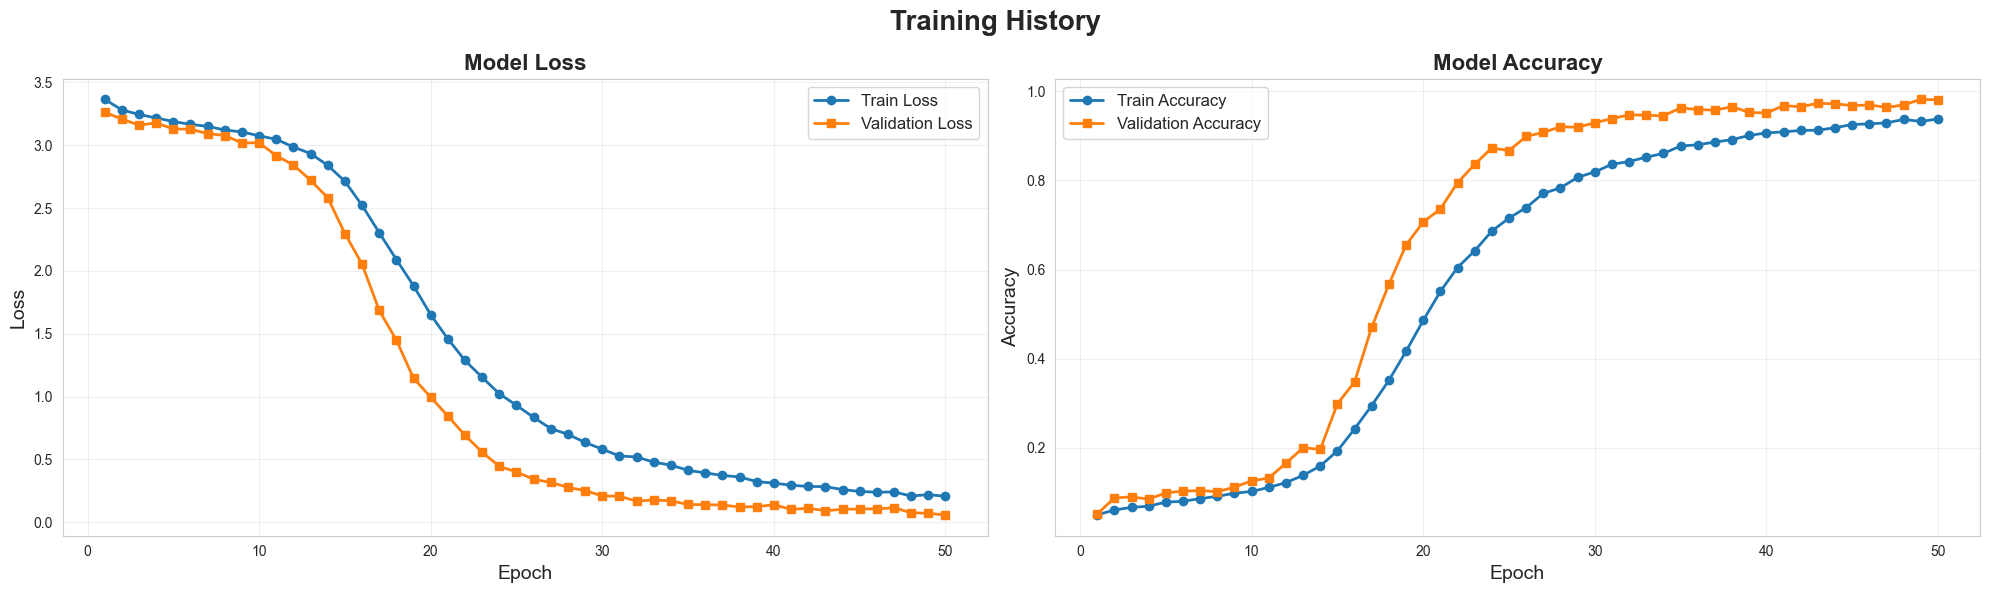

   ✅ Saved: training_curves.png


In [7]:
# ============================================================================
# SECTION 9: PLOT TRAINING CURVES
# ============================================================================

print("\n📊 Plotting Training Curves...")

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Training History', fontsize=20, fontweight='bold')

if FRAMEWORK == 'pytorch':
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Loss curve
    axes[0].plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2, marker='o')
    axes[0].plot(epochs_range, history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
    axes[0].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curve
    axes[1].plot(epochs_range, history['train_acc'], label='Train Accuracy', linewidth=2, marker='o')
    axes[1].plot(epochs_range, history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s')
    axes[1].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
else:  # Keras
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # Loss curve
    axes[0].plot(epochs_range, history.history['loss'], label='Train Loss', linewidth=2, marker='o')
    axes[0].plot(epochs_range, history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
    axes[0].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curve
    axes[1].plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
    axes[1].plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
    axes[1].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: training_curves.png")


In [9]:
# ============================================================================
# SECTION 10: TESTING AND EVALUATION - PYTORCH
# ============================================================================

if FRAMEWORK == 'pytorch':
    
    print("\n🧪 Evaluating on Test Set...")
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(config.DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
# ============================================================================
# SECTION 11: TESTING AND EVALUATION - KERAS
# ============================================================================

else:  # FRAMEWORK == 'keras'
    
    print("\n🧪 Evaluating on Test Set...")
    
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    all_preds = np.argmax(predictions, axis=1)
    all_labels = test_generator.classes
    all_probs = predictions



🧪 Evaluating on Test Set...



📊 Generating Confusion Matrix...


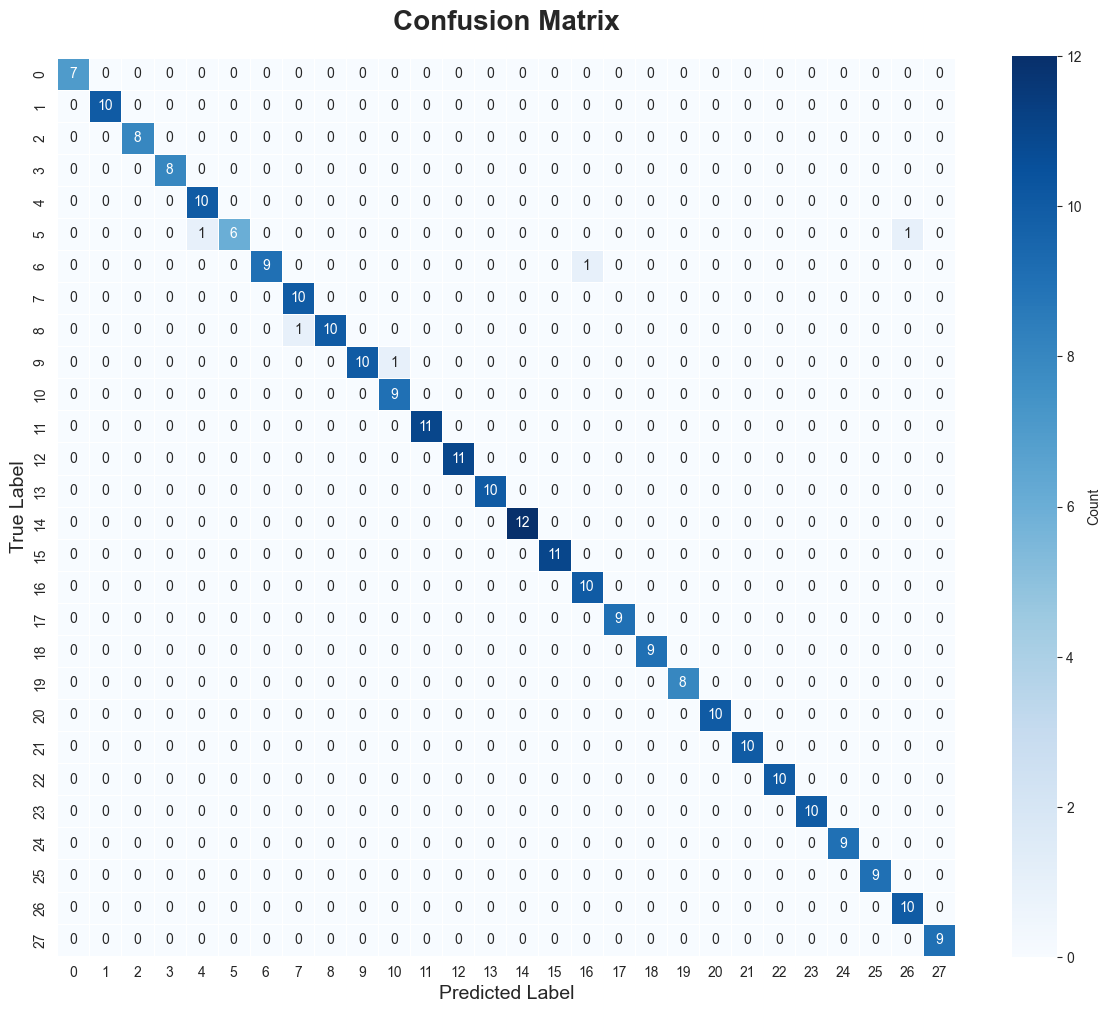

   ✅ Saved: confusion_matrix.png


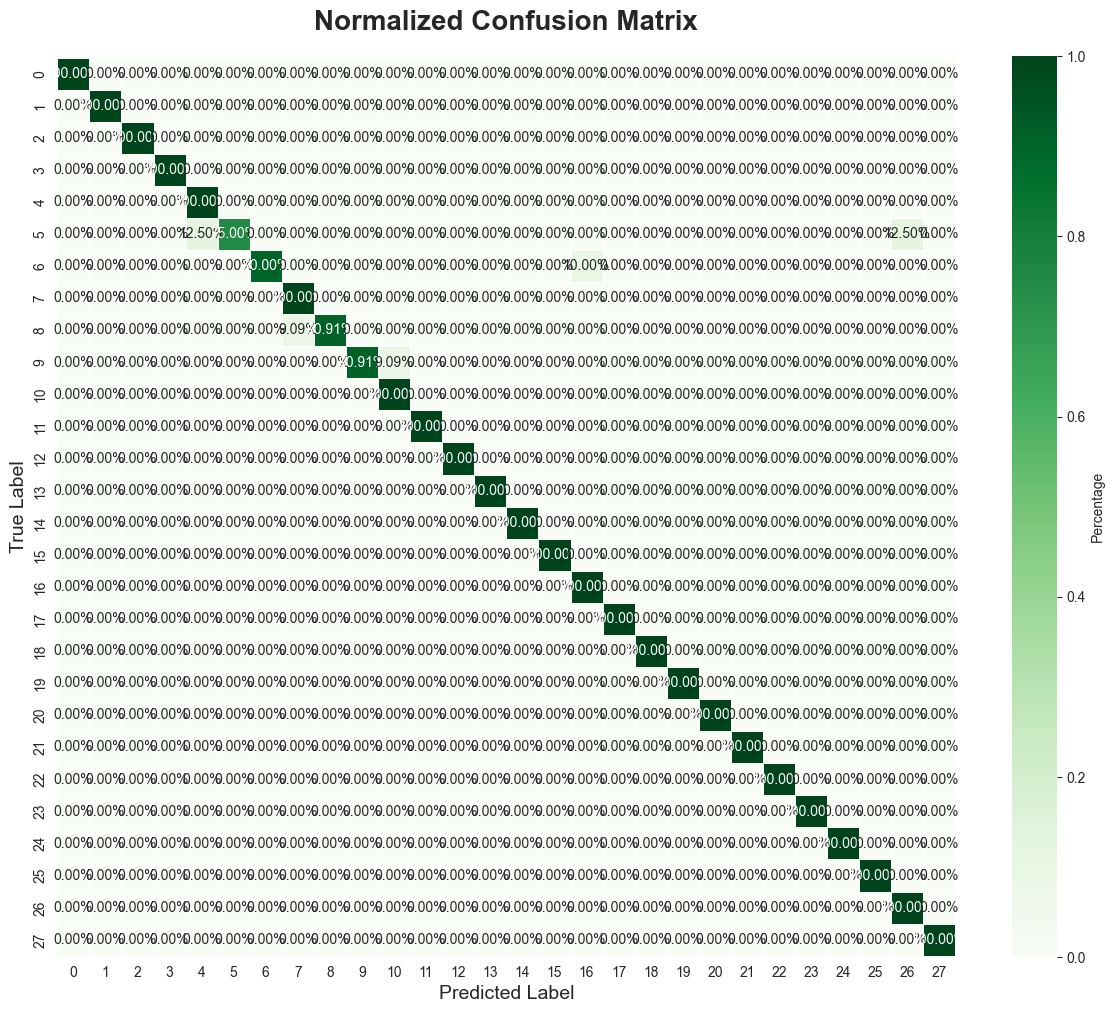

   ✅ Saved: confusion_matrix_normalized.png


In [10]:
# ============================================================================
# SECTION 12: CONFUSION MATRIX
# ============================================================================

print("\n📊 Generating Confusion Matrix...")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
            cbar_kws={'label': 'Count'}, linewidths=0.5)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: confusion_matrix.png")

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', square=True,
            cbar_kws={'label': 'Percentage'}, linewidths=0.5)
plt.title('Normalized Confusion Matrix', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: confusion_matrix_normalized.png")

In [11]:
# ============================================================================
# SECTION 13: EVALUATION METRICS
# ============================================================================

print("\n📈 Computing Evaluation Metrics...")

# Overall metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"\n{'='*80}")
print("OVERALL TEST METRICS")
print(f"{'='*80}")
print(f"   Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

# Per-class metrics
print(f"\n{'='*80}")
print("PER-CLASS METRICS")
print(f"{'='*80}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=[f'Class {i}' for i in range(config.NUM_CLASSES)],
                          digits=4))

# Create metrics DataFrame
per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

metrics_df = pd.DataFrame({
    'Class': [f'Class {i}' for i in range(config.NUM_CLASSES)],
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1,
    'Support': cm.sum(axis=1)
})

print("\n" + metrics_df.to_string(index=False))


📈 Computing Evaluation Metrics...

OVERALL TEST METRICS
   Accuracy:  0.9815 (98.15%)
   Precision: 0.9832
   Recall:    0.9815
   F1-Score:  0.9811

PER-CLASS METRICS

Classification Report:
              precision    recall  f1-score   support

     Class 0     1.0000    1.0000    1.0000         7
     Class 1     1.0000    1.0000    1.0000        10
     Class 2     1.0000    1.0000    1.0000         8
     Class 3     1.0000    1.0000    1.0000         8
     Class 4     0.9091    1.0000    0.9524        10
     Class 5     1.0000    0.7500    0.8571         8
     Class 6     1.0000    0.9000    0.9474        10
     Class 7     0.9091    1.0000    0.9524        10
     Class 8     1.0000    0.9091    0.9524        11
     Class 9     1.0000    0.9091    0.9524        11
    Class 10     0.9000    1.0000    0.9474         9
    Class 11     1.0000    1.0000    1.0000        11
    Class 12     1.0000    1.0000    1.0000        11
    Class 13     1.0000    1.0000    1.0000       


📊 Creating Metrics Visualizations...


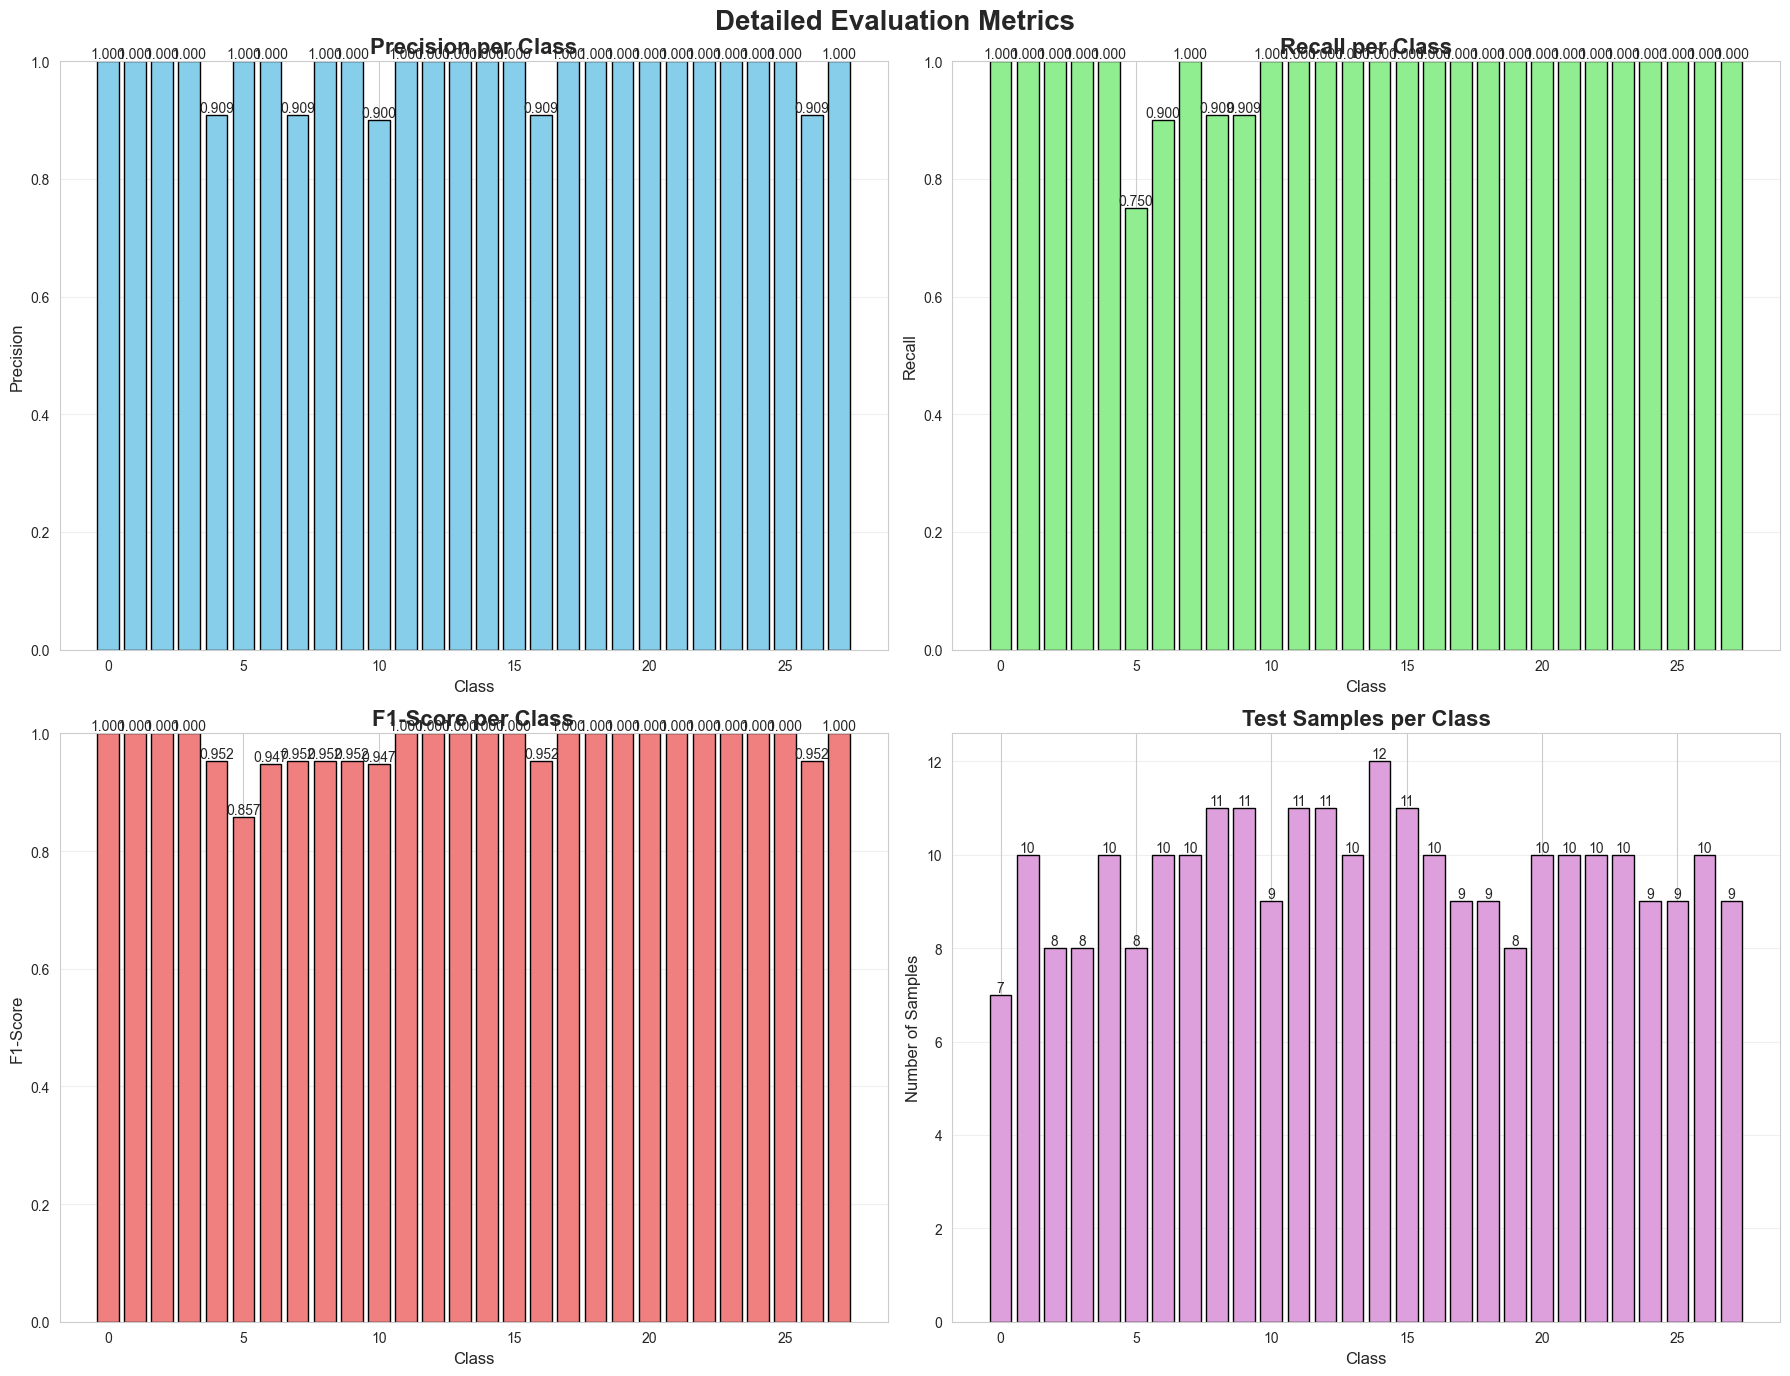

   ✅ Saved: evaluation_metrics.png


In [12]:
# ============================================================================
# SECTION 14: VISUALIZATION OF METRICS
# ============================================================================

print("\n📊 Creating Metrics Visualizations...")

# Plot per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Detailed Evaluation Metrics', fontsize=20, fontweight='bold')

# 1. Per-class Precision
ax1 = axes[0, 0]
bars1 = ax1.bar(range(config.NUM_CLASSES), per_class_precision, color='skyblue', edgecolor='black')
ax1.set_title('Precision per Class', fontsize=16, fontweight='bold')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 2. Per-class Recall
ax2 = axes[0, 1]
bars2 = ax2.bar(range(config.NUM_CLASSES), per_class_recall, color='lightgreen', edgecolor='black')
ax2.set_title('Recall per Class', fontsize=16, fontweight='bold')
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Recall', fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Per-class F1-Score
ax3 = axes[1, 0]
bars3 = ax3.bar(range(config.NUM_CLASSES), per_class_f1, color='lightcoral', edgecolor='black')
ax3.set_title('F1-Score per Class', fontsize=16, fontweight='bold')
ax3.set_xlabel('Class', fontsize=12)
ax3.set_ylabel('F1-Score', fontsize=12)
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 4. Samples per class
ax4 = axes[1, 1]
bars4 = ax4.bar(range(config.NUM_CLASSES), cm.sum(axis=1), color='plum', edgecolor='black')
ax4.set_title('Test Samples per Class', fontsize=16, fontweight='bold')
ax4.set_xlabel('Class', fontsize=12)
ax4.set_ylabel('Number of Samples', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: evaluation_metrics.png")


📊 Creating ROC Curves...


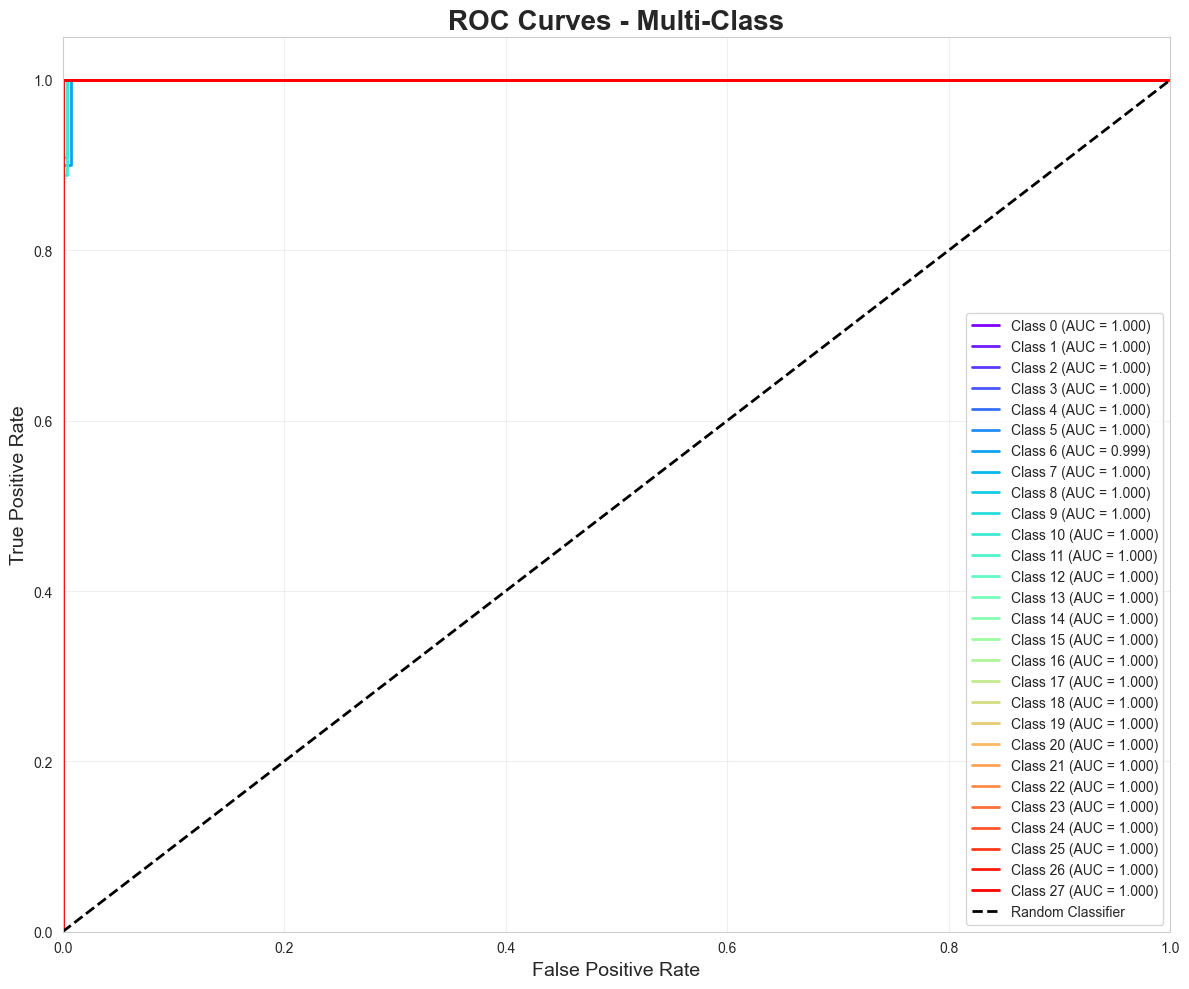

   ✅ Saved: roc_curves.png

   Mean AUC: 0.9999


In [13]:
# ============================================================================
# SECTION 15: ROC CURVE (for multi-class)
# ============================================================================

print("\n📊 Creating ROC Curves...")

# Binarize labels for ROC curve
y_test_bin = label_binarize(all_labels, classes=range(config.NUM_CLASSES))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(config.NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], all_probs[:, i])

# Plot ROC curves
plt.figure(figsize=(12, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, config.NUM_CLASSES))

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves - Multi-Class', fontsize=20, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: roc_curves.png")

# Average AUC
mean_auc = np.mean(list(roc_auc.values()))
print(f"\n   Mean AUC: {mean_auc:.4f}")



📸 Creating Sample Predictions Visualization...
   Loading dataset from dataset_augmented/test...
   Found 270 images, processing...
   ✅ Loaded 270 valid images
   📦 Caching images in memory...
   ✅ All images cached in memory!


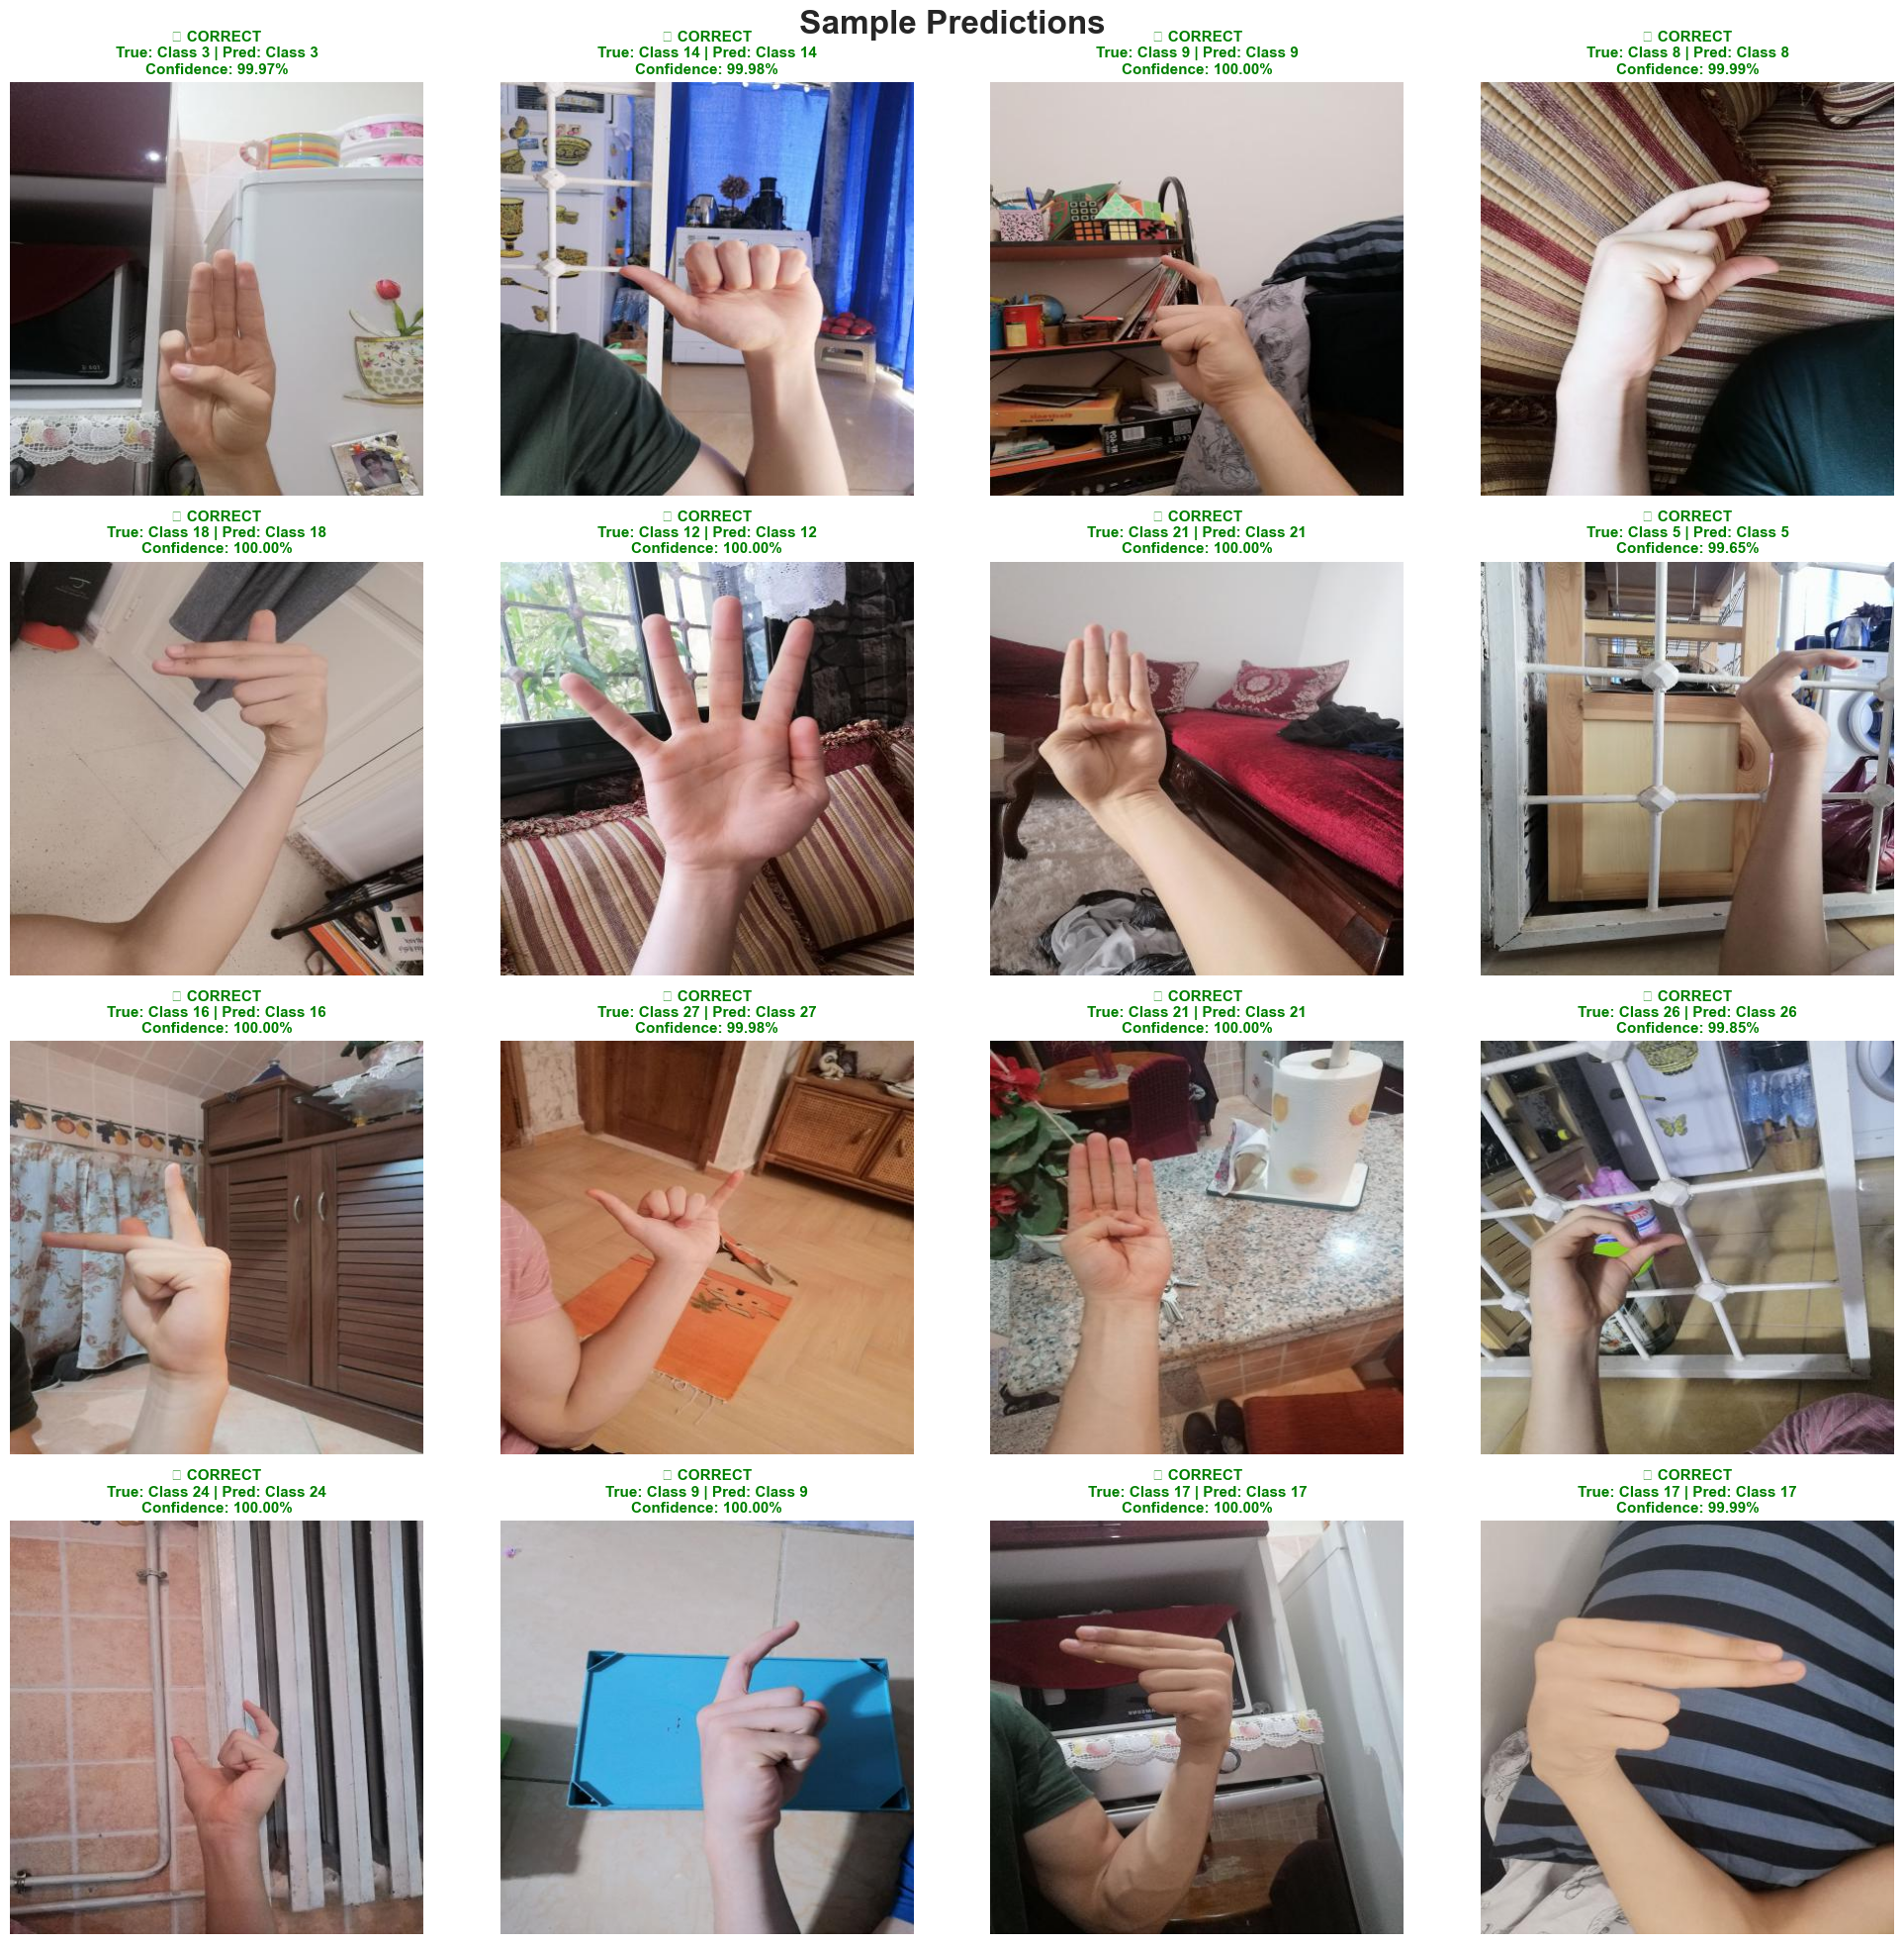

   ✅ Saved: sample_predictions.png


In [14]:
# ============================================================================
# SECTION 16: SAMPLE PREDICTIONS VISUALIZATION
# ============================================================================

print("\n📸 Creating Sample Predictions Visualization...")

# Get some test samples
if FRAMEWORK == 'pytorch':
    test_dataset_no_transform = HandSignDataset(config.TEST_DIR, transform=None)
    sample_indices = np.random.choice(len(test_dataset_no_transform), 16, replace=False)
else:
    test_df_sample = test_df.sample(16)
    sample_indices = test_df_sample.index

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Sample Predictions', fontsize=24, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < len(sample_indices):
        sample_idx = sample_indices[idx]
        
        if FRAMEWORK == 'pytorch':
            img, true_label = test_dataset_no_transform[sample_idx]
            img_array = np.array(img)
            
            # Get prediction
            img_tensor = test_transform(img).unsqueeze(0).to(config.DEVICE)
            with torch.no_grad():
                output = model(img_tensor)
                prob = torch.softmax(output, dim=1)
                pred_label = torch.argmax(prob, dim=1).item()
                confidence = prob[0, pred_label].item()
        else:
            img_path = test_df.iloc[sample_idx]['filename']
            true_label = int(test_df.iloc[sample_idx]['class'])
            img_array = cv2.imread(img_path)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            
            pred_label = all_preds[sample_idx]
            confidence = all_probs[sample_idx, pred_label]
        
        # Display image
        ax.imshow(img_array)
        
        # Set title with color coding
        is_correct = (pred_label == true_label)
        color = 'green' if is_correct else 'red'
        status = '✓ CORRECT' if is_correct else '✗ WRONG'
        
        title = f'{status}\nTrue: Class {true_label} | Pred: Class {pred_label}\nConfidence: {confidence:.2%}'
        ax.set_title(title, fontsize=11, fontweight='bold', color=color)
        ax.axis('off')
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(4)
            spine.set_visible(True)
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✅ Saved: sample_predictions.png")

In [15]:
# ============================================================================
# SECTION 17: SAVE FINAL RESULTS
# ============================================================================

print("\n💾 Saving Final Results...")

# Save metrics to CSV
final_results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Mean AUC'],
    'Value': [test_accuracy, test_precision, test_recall, test_f1, mean_auc]
}
results_df = pd.DataFrame(final_results)
results_df.to_csv('test_results.csv', index=False)
print("   ✅ Saved: test_results.csv")

# Save per-class metrics
metrics_df.to_csv('per_class_metrics.csv', index=False)
print("   ✅ Saved: per_class_metrics.csv")

# Save confusion matrix
cm_df = pd.DataFrame(cm, 
                     columns=[f'Pred_{i}' for i in range(config.NUM_CLASSES)],
                     index=[f'True_{i}' for i in range(config.NUM_CLASSES)])
cm_df.to_csv('confusion_matrix.csv')
print("   ✅ Saved: confusion_matrix.csv")



💾 Saving Final Results...
   ✅ Saved: test_results.csv
   ✅ Saved: per_class_metrics.csv
   ✅ Saved: confusion_matrix.csv


In [16]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ TRAINING AND EVALUATION COMPLETE!")
print("="*80)

print(f"\n📊 Final Test Results:")
print(f"   🎯 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   🎯 Precision: {test_precision:.4f}")
print(f"   🎯 Recall:    {test_recall:.4f}")
print(f"   🎯 F1-Score:  {test_f1:.4f}")
print(f"   🎯 Mean AUC:  {mean_auc:.4f}")

print(f"\n📁 Generated Files:")
print(f"   📈 training_curves.png")
print(f"   📊 confusion_matrix.png")
print(f"   📊 confusion_matrix_normalized.png")
print(f"   📊 evaluation_metrics.png")
print(f"   📊 roc_curves.png")
print(f"   📸 sample_predictions.png")
print(f"   💾 test_results.csv")
print(f"   💾 per_class_metrics.csv")
print(f"   💾 confusion_matrix.csv")
if FRAMEWORK == 'pytorch':
    print(f"   🤖 best_model.pth")
else:
    print(f"   🤖 best_model.h5")

print("\n" + "="*80)
print("🎉 All done! Your custom CNN is trained and evaluated.")
print("="*80)


✅ TRAINING AND EVALUATION COMPLETE!

📊 Final Test Results:
   🎯 Accuracy:  0.9815 (98.15%)
   🎯 Precision: 0.9832
   🎯 Recall:    0.9815
   🎯 F1-Score:  0.9811
   🎯 Mean AUC:  0.9999

📁 Generated Files:
   📈 training_curves.png
   📊 confusion_matrix.png
   📊 confusion_matrix_normalized.png
   📊 evaluation_metrics.png
   📊 roc_curves.png
   📸 sample_predictions.png
   💾 test_results.csv
   💾 per_class_metrics.csv
   💾 confusion_matrix.csv
   🤖 best_model.pth

🎉 All done! Your custom CNN is trained and evaluated.
